In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
ed = tfp.edward2
import sys
sys.path.append("../")
from future_features import tape
import numpy as np
from plot_utils import plot_source_distributions, plot_ifa_parameters_and_ppc
%load_ext autoreload
%autoreload 2

/home/folzd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from testsuite import MAP_model, neg_log_lik

/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/im

In [3]:
from tfpmodels import independentFactorAnalysis, centeredIndependentFactorAnalysis
from tfpmodels import centeredIndependentFactorAnalysisTest
from mapper import Mapper

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import FastICA, PCA

In [5]:
sess = tf.InteractiveSession()

In [6]:
n_components_in_mixture = 10
n_sources = 2
n_features = 2
n_observations = 5000

In [7]:
ifa = Mapper(centeredIndependentFactorAnalysis, 'ifa2', ['data'], n_observations=n_observations, n_components_in_mixture=n_components_in_mixture, n_features=n_features, n_sources=n_sources, mixture_component_var_concentration=.1*3, mixture_component_var_rate=1.*3,data_var_concentration=.1*3,data_var_rate=10.*3)

In [8]:
ifa.unconstrained_variables

{'mixture_component_var': <tf.Variable 'ifa2/mixture_component_var:0' shape=(2, 10) dtype=float32_ref>,
 'mixture_weights': <tf.Variable 'ifa2/mixture_weights:0' shape=(2, 9) dtype=float32_ref>,
 'sources': <tf.Variable 'ifa2/sources:0' shape=(5000, 2) dtype=float32_ref>,
 'factor_loadings': <tf.Variable 'ifa2/factor_loadings:0' shape=(2, 2) dtype=float32_ref>,
 'data_var': <tf.Variable 'ifa2/data_var:0' shape=(1, 2) dtype=float32_ref>}

In [9]:
generated = sess.run(ifa.tape)

In [57]:
fica = FastICA(n_components=n_sources).fit(generated['data']).mixing_.T
#loss, train_op = ifa.adam_optimizer(data=generated['data'], learning_rate=0.005)
loss, opt = ifa.bfgs_optimizer(data=generated['data'])
init_ops = [tf.global_variables_initializer()]

# Initialize in true parameters, as a sanity check
true_parameters = dict(generated)
#init_ops.append(ifa.assigner(**true_parameters))

# FastICA, large SNR, uniformish mixing weight initialization
init_ops.append(tf.assign(ifa.unconstrained_variables['factor_loadings'], fica,name='initialize_directions'))
init_ops.append(tf.assign(ifa.unconstrained_variables['mixture_component_var'], 10*generated['data'].var()*np.random.rand(n_sources,n_components_in_mixture),name='initialize_signal_variance'))
init_ops.append(tf.assign(ifa.unconstrained_variables['data_var'], 1e-3*np.ones(ifa.unconstrained_variables['data_var'].shape),name='initialize_noise_variance'))
init_ops.append(tf.assign(ifa.unconstrained_variables['mixture_weights'], np.ones(ifa.unconstrained_variables['mixture_weights'].shape)/n_components_in_mixture,name='initialize_noise_variance'))

#initialized_parameters = sess.run(ifa.variables)
#initialized_parameters.pop('sources')
#train_nll_init = neg_log_lik(initialized_parameters,centeredIndependentFactorAnalysisTest,generated['data'])
#sess.run(tf.assign(ifa.unconstrained_variables['sources'], 2*np.ones(ifa.variable_shapes['sources'])))
def plot_stuff(estimated_parameters):
    return plot_ifa_parameters_and_ppc(estimated_parameters, true_parameters, sess)
accparams = []
def accumulate_parameters(estimated_parameters):
    accparams.append(estimated_parameters)
sess.run([init_ops])
opt.minimize(loss_callback=accumulate_parameters,fetches=[ifa.variables])
#opt.minimize(loss_callback=plot_stuff,fetches=[ifa.variables])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -49621.464844
  Number of iterations: 58
  Number of functions evaluations: 136


In [58]:
len(accparams)

136

In [59]:
true_parameters

{'mixture_component_var': array([[9.75564774e-03, 2.02828661e-01, 1.29176095e-01, 7.14199909e-04,
         5.33923554e-08, 6.79045031e-03, 6.09757662e-01, 1.03586651e-02,
         8.61317292e-03, 7.35749826e-02],
        [4.34569009e-02, 2.94289179e-03, 2.73006618e-01, 2.17520846e-09,
         2.59128738e-05, 1.13029696e-01, 4.11748663e-02, 1.40650421e-01,
         2.97179539e-02, 8.85684881e-03]], dtype=float32),
 'mixture_weights': array([[0.0145886 , 0.14752977, 0.06689967, 0.31324932, 0.14884578,
         0.21800734, 0.00360221, 0.0239338 , 0.04868014, 0.01466335],
        [0.03404675, 0.1343362 , 0.13335161, 0.04022704, 0.06842972,
         0.02800846, 0.1283563 , 0.09649101, 0.19575277, 0.14100014]],
       dtype=float32),
 'sources': array([[ 0.04317466, -0.16254357],
        [-0.00183885,  0.00279925],
        [-0.5687474 , -0.11409852],
        ...,
        [ 0.07991692,  0.10646608],
        [-0.00951644, -0.06405121],
        [-0.0683721 ,  0.0026757 ]], dtype=float32),
 'fa

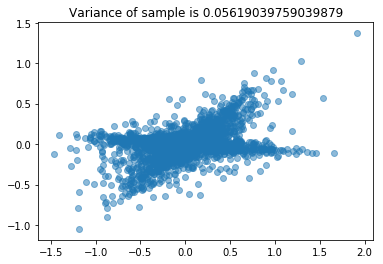

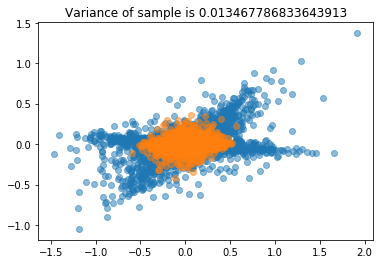

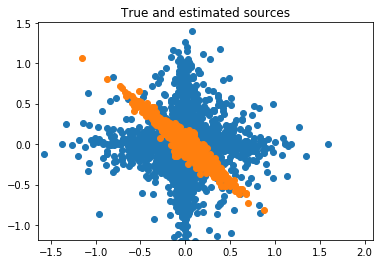

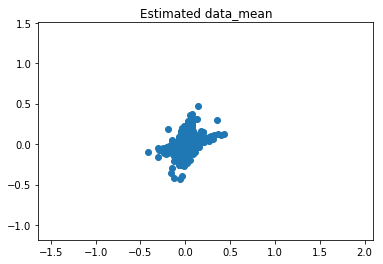

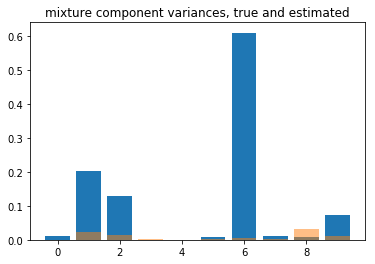

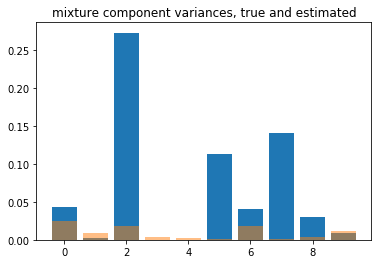

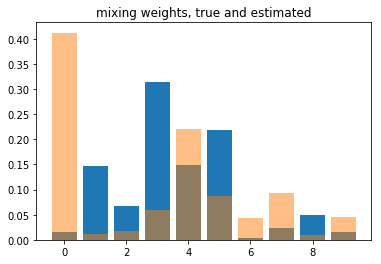

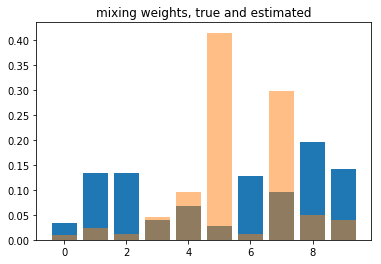

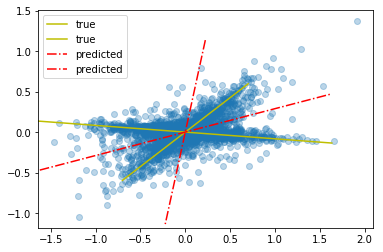

In [68]:
plot_ifa_parameters_and_ppc(accparams[50], true_parameters, sess)

In [11]:
# ADAM training
#t = []
#num_epochs = 3000
#sess.run(init_ops)
#for i in range(num_epochs):
#    sess.run(train_op)
#    if i % 5 == 0:
#        current_loss = sess.run(loss)
#        t.append(current_loss)
#plt.plot(np.arange(num_epochs,step=5)*5,t)

In [12]:
true_parameters['data_var']

array([[0.00236716, 0.00050603]], dtype=float32)

In [13]:
true_parameters['sources'].var(0)

array([0.04526931, 0.06599595], dtype=float32)

In [14]:
map_estimates = dict(ifa.variables)
map_estimates.pop('sources')

<tf.Tensor 'ifa2/sources/read:0' shape=(5000, 2) dtype=float32>

In [24]:
testmodel,source, data_mean = centeredIndependentFactorAnalysisTest(n_observations=n_observations, mc_samples=1, **map_estimates)
#source_sample = sess.run(source.distribution.sample((5000)))
#source_sample.var(0)

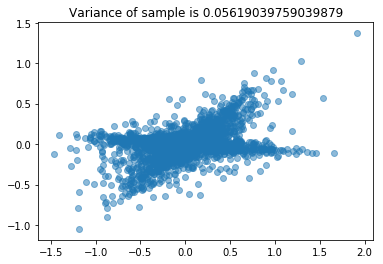

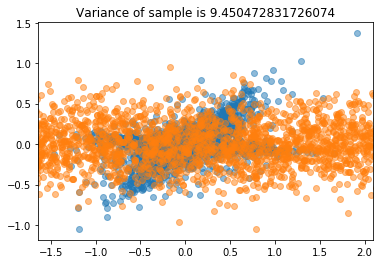

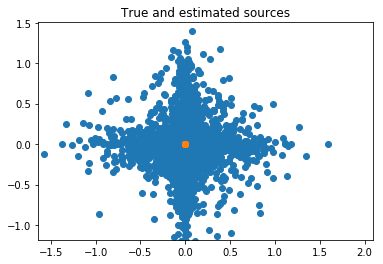

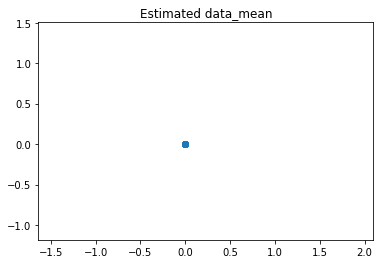

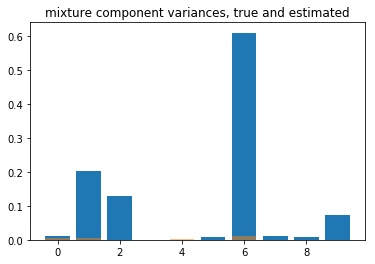

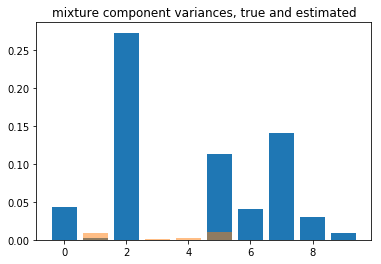

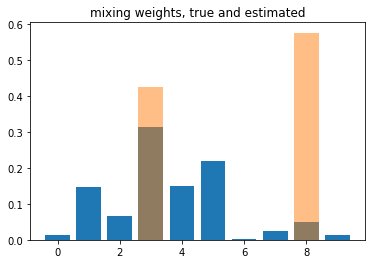

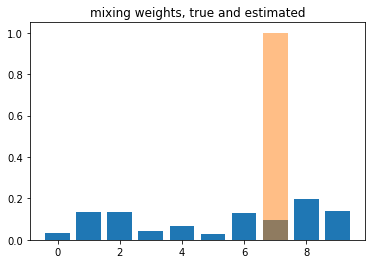

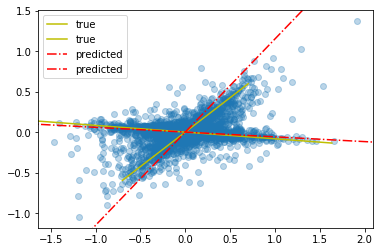

In [47]:
plot_ifa_parameters_and_ppc(ifa.variables, generated, sess)

In [ ]:
train_nll = neg_log_lik(map_estimates,centeredIndependentFactorAnalysisTest,generated['data'])

In [ ]:
sess.run(train_nll_init)

In [ ]:
# run train_nll 100 times to estimate variance of the log-likelihood estimate
#train_nlls = []
#for i in range(100):
    #train_nlls.append(sess.run(train_nll_init))
#train_nlls = np.array(train_nlls)
#print(train_nlls)
#print(train_nlls.mean())
#print(train_nlls.std())

In [ ]:
generated_vars.pop('data')
train_nll_true_model = neg_log_lik(generated_vars,centeredIndependentFactorAnalysisTest,generated['data'])

In [ ]:
sess.run(train_nll_true_model)

In [ ]:
print(generated['mixture_component_var'])
print(map_estimate_vars['mixture_component_var'])

In [ ]:
print(generated['mixture_component_var'].mean(1))
print(map_estimate_vars['mixture_component_var'].mean(1))

In [ ]:
print(generated['data_var'])
print(map_estimate_vars['data_var'])

In [ ]:
plt.matshow(np.abs(cosine_similarity(generated['factor_loadings'],map_estimate_vars['factor_loadings'])),cmap='coolwarm',vmin=0,vmax=1)
plt.colorbar()

In [ ]:
generated_vars

In [ ]:
map_estimate_vars

In [ ]:
try:
    generated_vars.pop('sources')
except:
    pass
for param_pair in zip(generated_vars.values(),map_estimate_vars.values()):
    print(param_pair)
    print(np.allclose(*param_pair,rtol=0.001))

In [ ]:
param_pair

In [ ]:
np.allclose(*param_pair)